In [1]:
!nvidia-smi

Thu Aug 24 14:47:02 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   30C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


In [ ]:
# Reloading
importlib.reload(ext)
importlib.reload(utils)
importlib.reload(metrics)
importlib.reload(visuals)
print("All Done")

In [3]:
%%time
modelpath   = "data/models/UNIF-10N-25T-200E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-200E-235R.gz"
testpath    = "data/sets/ACTS-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)

if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")   

CPU times: user 24.3 s, sys: 868 ms, total: 25.1 s
Wall time: 25.2 s


In [4]:
%%time
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
train = [event for event in train if len(pd.unique(event["cluster_id"])) ]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))

Train is list of 4800 events.
Test is list of 55781 events.
CPU times: user 10.2 s, sys: 348 ms, total: 10.5 s
Wall time: 10.5 s


In [5]:
order = ["phi", "r", "z"]

In [ ]:
print(sorted(pd.unique()))

Train 29430
Number of Hits: 186
Number of Tracks: 13


<IPython.core.display.Javascript object>


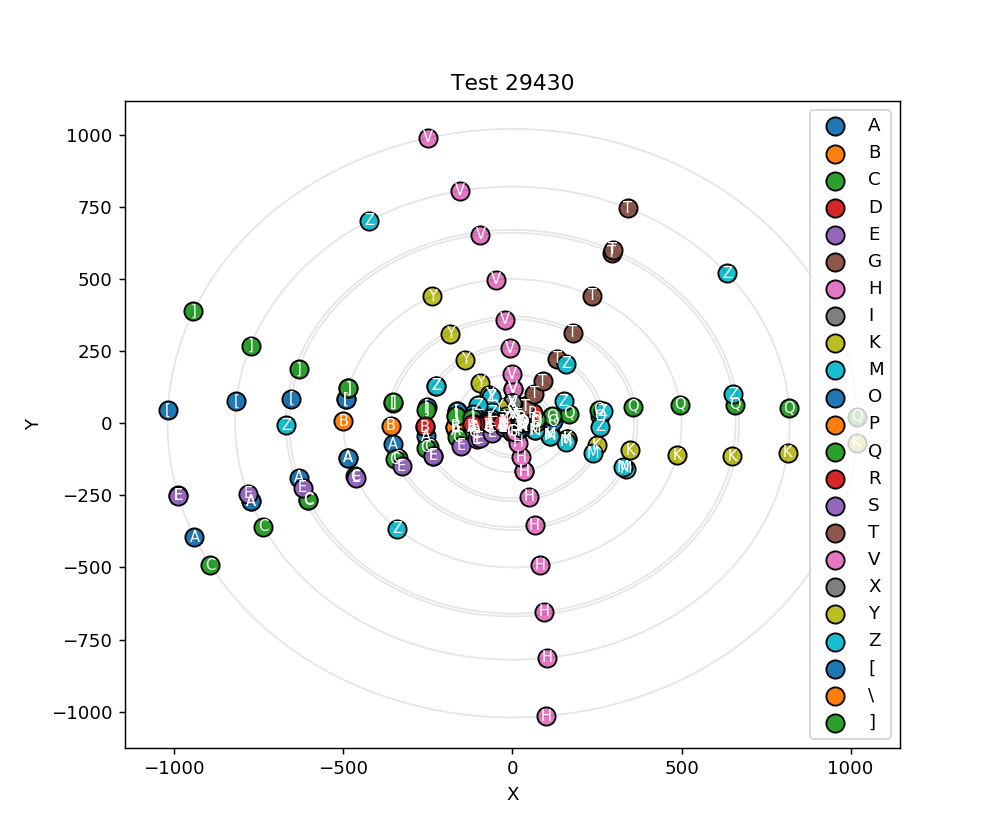

[30.0, 70.0, 110.0, 120.0, 170.0, 260.0, 270.0, 360.0, 370.0, 500.0, 660.0, 670.0, 820.0, nan, 1020.0]


In [9]:
n = np.random.randint(len(test))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(test[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(test[n])))
visuals.Plot2D(test[n], order).plot(mode="xy", title="Test {}".format(n))
print(sorted(pd.unique(test[n]["r"])))

In [ ]:
visuals.display(train[n], order)

In [ ]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(Bidirectional(
    GRU(
        units=256, 
        return_sequences=True,
        recurrent_dropout=2/5,
        implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=2/5))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

In [ ]:
%%time
train_input  = ext.extract_input (train, order)
train_target = ext.extract_output(train, order)
test_input   = ext.extract_input (test,  order)
test_output  = ext.extract_output(test,  order)
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_output.shape)

In [ ]:
model = keras.models.load_model(modelpath)

In [ ]:
%%time
# 32 + 32 + 64
epochs     = 32
batch_size = 64
histories.append(model.fit(
    train_input,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_input, test_output),
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

In [ ]:
%%time
guesses          = model.predict(test_input)
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

In [ ]:
n = 4
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy")
d = visuals.Plot2D(test[n], order).plot(mode="xy")

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")